# 基于截断策略的机器阅读理解任务实现

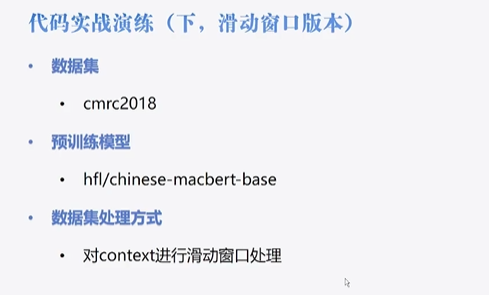

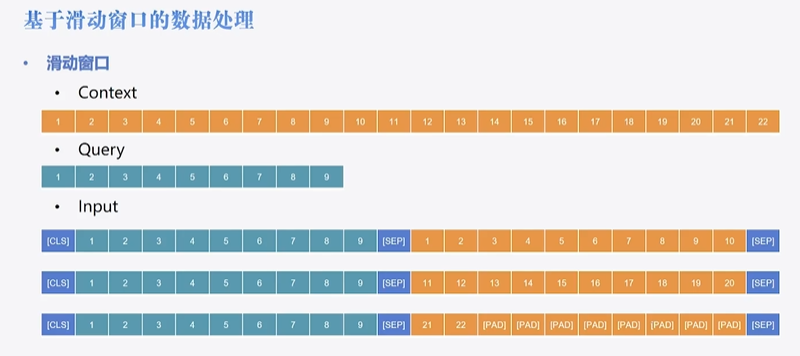

有重叠的滑动窗口，例如下面重叠=2：

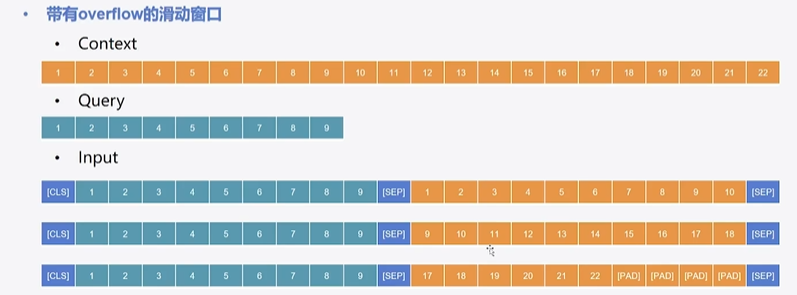

结果预测：聚合

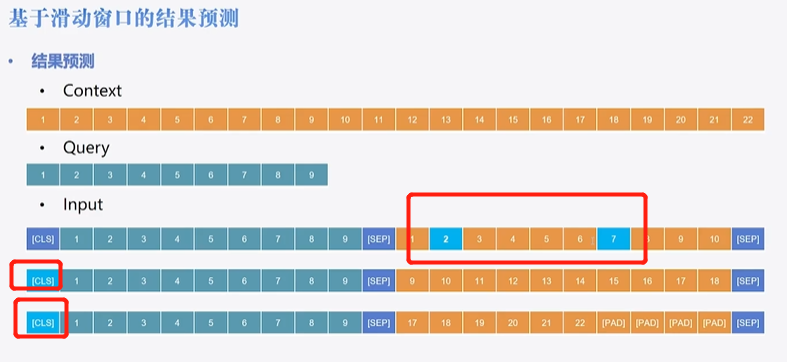

## Step1 导入相关包

In [1]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 数据集加载

In [2]:
# 如果可以联网，直接使用load_dataset进行加载
#datasets = load_dataset("cmrc2018", cache_dir="data")
# 如果无法联网，则使用下面的方式加载数据集
datasets = DatasetDict.load_from_disk("mrc_data")
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 10142
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 3219
    })
    test: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1002
    })
})

In [3]:
datasets["train"][0]

{'id': 'TRAIN_186_QUERY_0',
 'context': '范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机。1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，同年年底被擢升为枢机；2009年2月离世。范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南神父带到河内继续其学业。范廷颂于1940年在河内大修道院完成神学学业。范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务。1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民。1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范廷颂仍然留在河内。翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕。1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天主的爱」。由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作。范廷颂除了面对战争、贫困、被当局迫害天主教会等问题外，也秘密恢复修院、创建女修会团体等。1990年，教宗若望保禄二世在同年6月18日擢升范廷颂为天主教河内总教区宗座署理以填补该教区总主教的空缺。1994年3月23日，范廷颂被教宗若望保禄二世擢升为天主教河内总教区总主教并兼天主教谅山教区宗座署理；同年11月26日，若望保禄二世擢升范廷颂为枢机。范廷颂在1995年至2001年期间出任天主教越南主教团主席。2003年4月26日，教宗若望保禄二世任命天主教谅山教区兼天主教高平教区吴光杰主教为天主教河内总教区署理主教；及至2005年2月19日，范廷颂因获批辞去总主教职务而荣休；吴光杰同日真除天主教河内总教区总主教职务。范廷颂于2009年2月22日清晨在河内离世，享年89岁；其葬礼于同月26日上午在天主教河内总教区总主教座堂举行。',
 'question': '范廷颂是什么时候被任为主教的？',
 'answers': {'text': ['1963年'], 'answer_start': [30]}}

## Step3 数据预处理

In [3]:
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-base")
tokenizer

BertTokenizerFast(name_or_path='hfl/chinese-macbert-base', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
sample_dataset = datasets["train"].select(range(10))

In [8]:
tokenized_examples = tokenizer(text=sample_dataset["question"],
                               text_pair=sample_dataset["context"],
                               return_offsets_mapping=True,
                               return_overflowing_tokens=True,  # 多滑动窗口
                               stride=128, # 滑动窗口内容重叠
                               max_length=384, truncation="only_second", padding="max_length")
tokenized_examples.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [7]:
tokenized_examples["overflow_to_sample_mapping"], len(tokenized_examples["overflow_to_sample_mapping"])
# 发现十条数据，被切成了29条

([0,
  0,
  0,
  1,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  3,
  4,
  4,
  4,
  5,
  5,
  5,
  6,
  6,
  6,
  7,
  7,
  7,
  8,
  8,
  8,
  9,
  9],
 29)

In [8]:
for sen in tokenizer.batch_decode(tokenized_examples["input_ids"][:3]):
    print(sen)

[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 范 廷 颂 枢 机 （ ， ） ， 圣 名 保 禄 · 若 瑟 （ ） ， 是 越 南 罗 马 天 主 教 枢 机 。 1963 年 被 任 为 主 教 ； 1990 年 被 擢 升 为 天 主 教 河 内 总 教 区 宗 座 署 理 ； 1994 年 被 擢 升 为 总 主 教 ， 同 年 年 底 被 擢 升 为 枢 机 ； 2009 年 2 月 离 世 。 范 廷 颂 于 1919 年 6 月 15 日 在 越 南 宁 平 省 天 主 教 发 艳 教 区 出 生 ； 童 年 时 接 受 良 好 教 育 后 ， 被 一 位 越 南 神 父 带 到 河 内 继 续 其 学 业 。 范 廷 颂 于 1940 年 在 河 内 大 修 道 院 完 成 神 学 学 业 。 范 廷 颂 于 1949 年 6 月 6 日 在 河 内 的 主 教 座 堂 晋 铎 ； 及 后 被 派 到 圣 女 小 德 兰 孤 儿 院 服 务 。 1950 年 代 ， 范 廷 颂 在 河 内 堂 区 创 建 移 民 接 待 中 心 以 收 容 到 河 内 避 战 的 难 民 。 1954 年 ， 法 越 战 争 结 束 ， 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 管 理 圣 若 望 小 修 院 ； 惟 在 1960 年 因 捍 卫 修 院 的 自 由 、 自 治 及 拒 绝 政 府 在 修 院 设 政 治 课 的 要 求 而 被 捕 。 1963 年 4 月 5 日 ， 教 宗 任 命 范 廷 颂 为 天 主 教 北 宁 教 区 主 教 ， 同 年 8 月 15 日 就 任 ； 其 牧 铭 为 「 我 信 [SEP]
[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 管 理 圣 若 望 小 修 院 ； 惟 在 1960 年 因 捍 卫 修 院 的 自 由 、 自 治 及 拒 

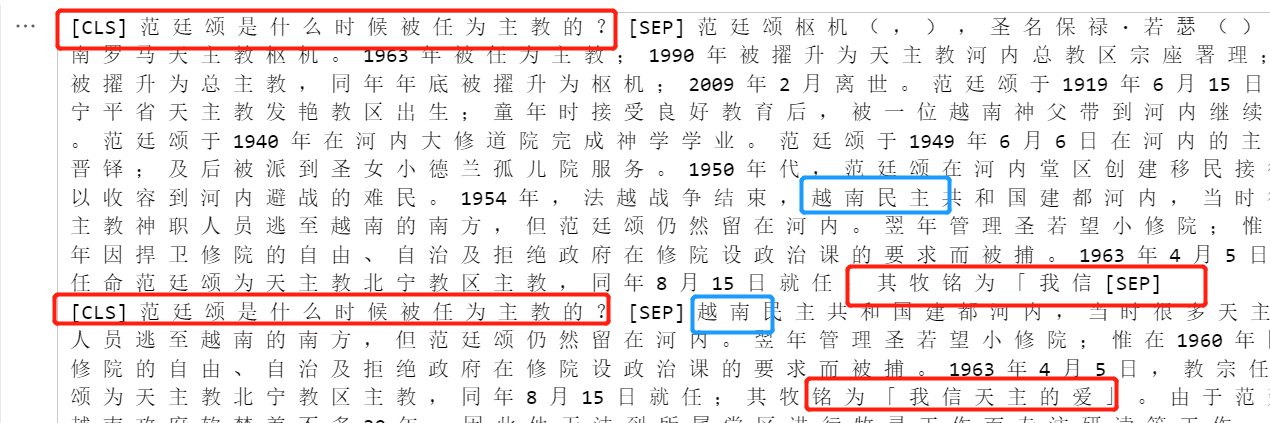

In [9]:
print(tokenized_examples["offset_mapping"][:3])

[[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), 

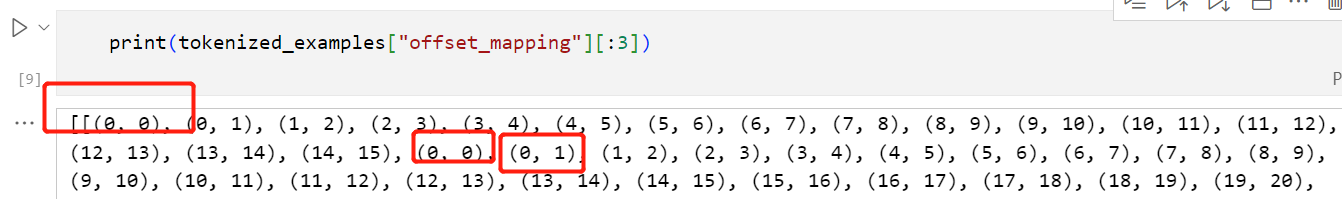

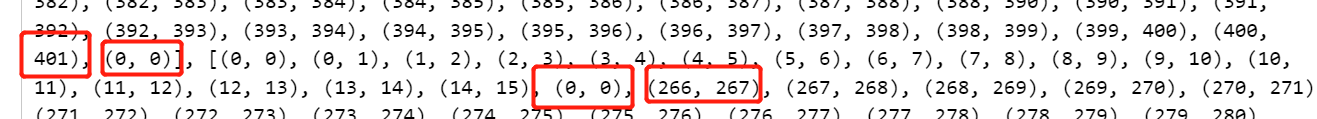

In [10]:
print(tokenized_examples["offset_mapping"][0], len(tokenized_examples["offset_mapping"][0]))

[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (

In [9]:
sample_mapping = tokenized_examples["overflow_to_sample_mapping"] # 句子被分成的部分的映射
print(sample_mapping)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9]


In [14]:
datasets['train']['id'][sample_mapping[0]]  # 当前这个滑动窗口句子，对应的原数据集id

'TRAIN_186_QUERY_0'

In [14]:
for idx, _ in enumerate(sample_mapping):
    answer = sample_dataset["answers"][sample_mapping[idx]]
    start_char = answer["answer_start"][0]
    end_char = start_char + len(answer["text"][0])
    # 定位答案在token中的起始位置和结束位置
    # 一种策略，我们要拿到context的起始和结束，然后从左右两侧向答案逼近

    context_start = tokenized_examples.sequence_ids(idx).index(1)
    context_end = tokenized_examples.sequence_ids(idx).index(None, context_start) - 1

    offset = tokenized_examples.get("offset_mapping")[idx]
    example_ids = []

    # 判断答案是否在context中
    if offset[context_end][1] < start_char or offset[context_start][0] > end_char:
        start_token_pos = 0
        end_token_pos = 0
    else:
        token_id = context_start
        while token_id <= context_end and offset[token_id][0] < start_char:
            token_id += 1
        start_token_pos = token_id
        token_id = context_end
        while token_id >= context_start and offset[token_id][1] > end_char:
            token_id -=1
        end_token_pos = token_id
        example_ids.append([sample_mapping[idx]])
        
    print(answer, start_char, end_char, context_start, context_end, start_token_pos, end_token_pos)
    print("token answer decode:", tokenizer.decode(tokenized_examples["input_ids"][idx][start_token_pos: end_token_pos + 1]))

{'text': ['1963年'], 'answer_start': [30]} 30 35 17 382 47 48
token answer decode: 1963 年
{'text': ['1963年'], 'answer_start': [30]} 30 35 17 382 0 0
token answer decode: [CLS]
{'text': ['1963年'], 'answer_start': [30]} 30 35 17 289 0 0
token answer decode: [CLS]
{'text': ['1990年被擢升为天主教河内总教区宗座署理'], 'answer_start': [41]} 41 62 15 382 53 70
token answer decode: 1990 年 被 擢 升 为 天 主 教 河 内 总 教 区 宗 座 署 理
{'text': ['1990年被擢升为天主教河内总教区宗座署理'], 'answer_start': [41]} 41 62 15 382 0 0
token answer decode: [CLS]
{'text': ['1990年被擢升为天主教河内总教区宗座署理'], 'answer_start': [41]} 41 62 15 283 0 0
token answer decode: [CLS]
{'text': ['范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生'], 'answer_start': [97]} 97 126 15 382 100 124
token answer decode: 范 廷 颂 于 1919 年 6 月 15 日 在 越 南 宁 平 省 天 主 教 发 艳 教 区 出 生
{'text': ['范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生'], 'answer_start': [97]} 97 126 15 382 0 0
token answer decode: [CLS]
{'text': ['范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生'], 'answer_start': [97]} 97 126 15 283 0 0
token answer decode: [CLS]
{'text': ['19

In [20]:
def process_func(examples):
    tokenized_examples = tokenizer(text=examples["question"],
                               text_pair=examples["context"],
                               return_offsets_mapping=True,
                               return_overflowing_tokens=True,
                               stride=128,
                               max_length=384, truncation="only_second", padding="max_length")
    # tokenized_examples的一条数据是一个滑动窗口
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    start_positions = []
    end_positions = []
    example_ids = []
    for idx, _ in enumerate(sample_mapping):
        answer = examples["answers"][sample_mapping[idx]]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        # 定位答案在token中的起始位置和结束位置
        # 一种策略，我们要拿到context的起始和结束，然后从左右两侧向答案逼近
        context_start = tokenized_examples.sequence_ids(idx).index(1)
        context_end = tokenized_examples.sequence_ids(idx).index(None, context_start) - 1
        offset = tokenized_examples.get("offset_mapping")[idx]
        # 判断答案是否在context中
        if offset[context_end][1] < start_char or offset[context_start][0] > end_char:
            start_token_pos = 0
            end_token_pos = 0
        else:
            token_id = context_start
            while token_id <= context_end and offset[token_id][0] < start_char:
                token_id += 1
            start_token_pos = token_id
            token_id = context_end
            while token_id >= context_start and offset[token_id][1] > end_char:
                token_id -=1
            end_token_pos = token_id
        start_positions.append(start_token_pos)
        end_positions.append(end_token_pos)
        example_ids.append(examples["id"][sample_mapping[idx]])  # 得到这个窗口在原文本的id
        tokenized_examples["offset_mapping"][idx] = [  # 第i个滑动窗口的offset_mapping
            (o if tokenized_examples.sequence_ids(idx)[k] == 1 else None)  # ==1是找context（第二句），不是第二句就把offset变成None，因为预测只来自第二句
            for k, o in enumerate(tokenized_examples["offset_mapping"][idx])
        ]

    
    tokenized_examples["example_ids"] = example_ids
    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions
    return tokenized_examples

In [21]:
tokenied_datasets = datasets.map(process_func, batched=True, remove_columns=datasets["train"].column_names)
tokenied_datasets

Map:   0%|          | 0/10142 [00:00<?, ? examples/s]

Map:   0%|          | 0/3219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_ids', 'start_positions', 'end_positions'],
        num_rows: 19189
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_ids', 'start_positions', 'end_positions'],
        num_rows: 6327
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_ids', 'start_positions', 'end_positions'],
        num_rows: 1988
    })
})

In [25]:
print(tokenied_datasets['train']['example_ids'][:5])

['TRAIN_186_QUERY_0', 'TRAIN_186_QUERY_0', 'TRAIN_186_QUERY_0', 'TRAIN_186_QUERY_1', 'TRAIN_186_QUERY_1']


In [17]:
print(tokenied_datasets["train"]["offset_mapping"][1])
# None就是question和特殊符号

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, [266, 267], [267, 268], [268, 269], [269, 270], [270, 271], [271, 272], [272, 273], [273, 274], [274, 275], [275, 276], [276, 277], [277, 278], [278, 279], [279, 280], [280, 281], [281, 282], [282, 283], [283, 284], [284, 285], [285, 286], [286, 287], [287, 288], [288, 289], [289, 290], [290, 291], [291, 292], [292, 293], [293, 294], [294, 295], [295, 296], [296, 297], [297, 298], [298, 299], [299, 300], [300, 301], [301, 302], [302, 303], [303, 304], [304, 305], [305, 306], [306, 307], [307, 308], [308, 309], [309, 310], [310, 311], [311, 312], [312, 313], [313, 314], [314, 315], [315, 316], [316, 317], [317, 318], [318, 319], [319, 320], [320, 321], [321, 325], [325, 326], [326, 327], [327, 328], [328, 329], [329, 330], [330, 331], [331, 332], [332, 333], [333, 334], [334, 335], [335, 336], [336, 337], [337, 338], [338, 339], [339, 340], [340, 341], [341, 342], [342, 343], [343, 344

In [18]:
tokenied_datasets["train"]["example_ids"][:10]

['TRAIN_186_QUERY_0',
 'TRAIN_186_QUERY_0',
 'TRAIN_186_QUERY_0',
 'TRAIN_186_QUERY_1',
 'TRAIN_186_QUERY_1',
 'TRAIN_186_QUERY_1',
 'TRAIN_186_QUERY_2',
 'TRAIN_186_QUERY_2',
 'TRAIN_186_QUERY_2',
 'TRAIN_186_QUERY_3']

In [19]:
import collections
# example 和 feature的映射
# example_id是原始数据集里数据的id，例如TRAIN_186_QUERY_0
# idx：预处理后的数据的id
example_to_feature = collections.defaultdict(list)
for idx, example_id in enumerate(tokenied_datasets["train"]["example_ids"][:10]):
    example_to_feature[example_id].append(idx)
example_to_feature
# 原始数据TRAIN_186_QUERY_0对应于预处理后的0、1、2三条数据

defaultdict(list,
            {'TRAIN_186_QUERY_0': [0, 1, 2],
             'TRAIN_186_QUERY_1': [3, 4, 5],
             'TRAIN_186_QUERY_2': [6, 7, 8],
             'TRAIN_186_QUERY_3': [9]})

## Step4 获取模型输出

In [20]:
import numpy as np
import collections

def get_result(start_logits, end_logits, exmaples, features):

    predictions = {}
    references = {} # 真实值

    # example（原始数据） 和 feature的映射：原始数据id 和预处理后数据id的映射
    example_to_feature = collections.defaultdict(list)
    for idx, example_id in enumerate(features["example_ids"]):
        example_to_feature[example_id].append(idx)

    # 最优答案候选
    n_best = 20
    # 最大答案长度
    max_answer_length = 30

    for example in exmaples:
        example_id = example["id"]
        context = example["context"]
        answers = []
        for feature_idx in example_to_feature[example_id]:
            start_logit = start_logits[feature_idx]
            end_logit = end_logits[feature_idx]
            offset = features[feature_idx]["offset_mapping"]
            start_indexes = np.argsort(start_logit)[::-1][:n_best].tolist()
            end_indexes = np.argsort(end_logit)[::-1][:n_best].tolist()  # [::-1]倒序
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offset[start_index] is None or offset[end_index] is None:
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    answers.append({
                        "text": context[offset[start_index][0]: offset[end_index][1]],
                        "score": start_logit[start_index] + end_logit[end_index]
                    })
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["score"]) # key=是排序依据
            predictions[example_id] = best_answer["text"]
        else:
            predictions[example_id] = ""
        references[example_id] = example["answers"]["text"]

    return predictions, references

## Step5 评估函数

In [21]:
from cmrc_eval import evaluate_cmrc

def metirc(pred):
    start_logits, end_logits = pred[0]
    if start_logits.shape[0] == len(tokenied_datasets["validation"]):
        p, r = get_result(start_logits, end_logits, datasets["validation"], tokenied_datasets["validation"])
    else:
        p, r = get_result(start_logits, end_logits, datasets["test"], tokenied_datasets["test"])
    return evaluate_cmrc(p, r)

## Step6 加载模型

In [22]:
model = AutoModelForQuestionAnswering.from_pretrained("hfl/chinese-macbert-base")

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step7 配置TrainingArguments

In [24]:
args = TrainingArguments(
    output_dir="models_for_qa",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=200,
    save_strategy="epoch",
    logging_steps=50,
    num_train_epochs=1
)

## Step8 配置Trainer

In [25]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenied_datasets["train"],
    eval_dataset=tokenied_datasets["validation"],
    data_collator=DefaultDataCollator(),
    compute_metrics=metirc  # 评估指标
)

## Step9 模型训练

In [26]:
trainer.train()

  0%|          | 0/600 [00:00<?, ?it/s]

{'loss': 2.9874, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.08}
{'loss': 1.7969, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.17}
{'loss': 1.6942, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.25}
{'loss': 1.5247, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.33}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 1.363970398902893, 'eval_avg': 75.30932950154663, 'eval_f1': 85.03928652716905, 'eval_em': 65.5793724759242, 'eval_total': 3219, 'eval_skip': 0, 'eval_runtime': 28.4484, 'eval_samples_per_second': 222.403, 'eval_steps_per_second': 6.96, 'epoch': 0.33}
{'loss': 1.4606, 'learning_rate': 2.916666666666667e-05, 'epoch': 0.42}
{'loss': 1.4789, 'learning_rate': 2.5e-05, 'epoch': 0.5}
{'loss': 1.4149, 'learning_rate': 2.0833333333333336e-05, 'epoch': 0.58}
{'loss': 1.4144, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.67}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 1.1983708143234253, 'eval_avg': 76.77974028535593, 'eval_f1': 86.45789622774821, 'eval_em': 67.10158434296365, 'eval_total': 3219, 'eval_skip': 0, 'eval_runtime': 29.4467, 'eval_samples_per_second': 214.863, 'eval_steps_per_second': 6.724, 'epoch': 0.67}
{'loss': 1.331, 'learning_rate': 1.25e-05, 'epoch': 0.75}
{'loss': 1.3906, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.83}
{'loss': 1.3069, 'learning_rate': 4.166666666666667e-06, 'epoch': 0.92}
{'loss': 1.3046, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 1.1734825372695923, 'eval_avg': 77.59102263163638, 'eval_f1': 87.272756664329, 'eval_em': 67.90928859894377, 'eval_total': 3219, 'eval_skip': 0, 'eval_runtime': 30.5264, 'eval_samples_per_second': 207.263, 'eval_steps_per_second': 6.486, 'epoch': 1.0}
{'train_runtime': 299.2545, 'train_samples_per_second': 64.123, 'train_steps_per_second': 2.005, 'train_loss': 1.5920880381266276, 'epoch': 1.0}


TrainOutput(global_step=600, training_loss=1.5920880381266276, metrics={'train_runtime': 299.2545, 'train_samples_per_second': 64.123, 'train_steps_per_second': 2.005, 'train_loss': 1.5920880381266276, 'epoch': 1.0})

## Step8 模型预测

In [27]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)
pipe

In [28]:
pipe(question="小明在哪里上班？", context="小明在北京上班")

{'score': 0.5118412971496582, 'start': 3, 'end': 5, 'answer': '北京'}